# Análisis de cartera
Esta sección tendrá los siguientes pasos:
- Conectarse a IB
- Extraer las empresas o ETFS en los que estoy invertido
- Análisis de cartera (iré desarrollando el análisis con forme vaya avanzando)

In [27]:
# Librerias
import time
import threading
import numpy as np
import pandas as pd
from datetime import datetime

# Enviroment
import os
from dotenv import load_dotenv
# Librerías de stock
import yfinance as yf
from ib_async import *
import mplfinance as mpf
from pandas_datareader import data as pdr
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData


# Librería de graficos
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
# Funcion para extraer la información de la columna contract
def extract_option_info(option_obj):
    return {
        'conId': option_obj.conId,
        'symbol': option_obj.symbol,
        'lastTradeDateOrContractMonth': option_obj.lastTradeDateOrContractMonth,
        'strike': option_obj.strike,
        'right': option_obj.right,
        'multiplier': option_obj.multiplier,
        'currency': option_obj.currency,
        'localSymbol': option_obj.localSymbol,
        'tradingClass': option_obj.tradingClass
    }

In [4]:
def obtener_precio_activo(symbol, strike=None, vencimiento=None, tipo='stock'):
    # Si es una acción
    if tipo == 'stock':
        ticker = yf.Ticker(symbol)
        precio_actual = ticker.history(period="1d")['Close'].iloc[-1]
        return precio_actual
    # Si es una opción (tipo = 'call' o 'put')
    elif tipo in ['call', 'put']:
        ticker = yf.Ticker(symbol)
        
        # Verificamos si el vencimiento es correcto
        if vencimiento not in ticker.options:
            print(f"No hay opciones con vencimiento {vencimiento} para {symbol}")
            return None
        
        # Obtenemos las opciones para la fecha de vencimiento
        opciones_vencimiento = ticker.option_chain(vencimiento)
        
        # Seleccionamos las opciones de tipo 'call' o 'put'
        if tipo == 'call':
            opciones_datos = opciones_vencimiento.calls
        elif tipo == 'put':
            opciones_datos = opciones_vencimiento.puts
        
        # Buscamos la opción con el strike correspondiente
        opcion = opciones_datos[opciones_datos['strike'] == strike]
        
        if opcion.empty:
            print(f"No se encontró opción con strike {strike} para {symbol}")
            return None
        else:
            # Devolvemos el precio de la opción
            return opcion['lastPrice'].iloc[0]
    else:
        print("Tipo de activo desconocido")
        return None

In [6]:
util.startLoop()  # uncomment this line when in a notebook

ib = IB()
ib.connect('127.0.0.1', 4001, clientId=1)

<IB connected to 127.0.0.1:4001 clientId=1>

Error 1100, reqId -1: Conectividad entre IB y TWS ha sido perdida
Error 1102, reqId -1: Conectividad entre IB y TWS ha sido restaurada - datos mantenidos: Las granjas siguientes est\u00e1n conectadas: eufarm; secdefeu. Las granjas siguientes no est\u00e1n conectadas: euhmds.


In [8]:
# Obtenemos las posiciones. Con manageAccounts tenemos el número de la cuenta
posiciones = ib.positions(account=ib.managedAccounts()[0])

# Hacemos un df
pos_df = pd.DataFrame(posiciones)

In [9]:
# Obtenemos un data frame a partir de la columna de contract
contracts_expand = pd.json_normalize(
    pos_df.loc[:,"contract"].apply(lambda x : extract_option_info(x))
    )

In [10]:
# Concatenamos ambos dfs
df_final = pd.concat([pos_df, contracts_expand], axis=1)

In [16]:
# Ponemos en formato fecha la columna lastTradeDateOrContractMonth
df_final["fecha_opciones"] = pd.to_datetime(df_final.loc[:,"lastTradeDateOrContractMonth"], format="%Y%m%d").astype("str")
# Ponemos call en las opciones call y stock en los activos que son acciones
df_final['right'] = np.where(df_final['right'] == 'C', 'call', np.where(df_final['right'] == '', 'stock', df_final['right']))

In [17]:
# Crear una nueva columna en el DataFrame para el precio actual de los activos financieros
df_final['precio_actual'] = df_final.apply(
    lambda row : obtener_precio_activo( # Usamos la función para descargarnos los prec actualizados
        symbol=row["symbol"] , 
        strike=row["strike"] , 
        vencimiento=row["fecha_opciones"],
        tipo=row["right"]), axis=1)

In [18]:
# Calcular el precio por unidad, ajustando para opciones (dividido entre 100 si no es stock)
df_final["precio_compra"] = np.where(
    df_final["right"] != "stock",  # Condición: si el tipo de activo no es stock
    df_final["avgCost"] / (df_final["position"] * 100),  # Dividir entre 100
    df_final["avgCost"] / df_final["position"]  # Caso contrario, sin ajuste
)
# Calculamos rentabilidad
df_final['rentabilidad'] = ((df_final['precio_actual'] - df_final['precio_compra']) / df_final['precio_compra']) * 100

# Calcular el valor total invertido y la rentabilidad total (si te interesa)
df_final['valor_actual'] = df_final['precio_actual'] * df_final['position']
# Calcular la rentabilidad total ajustando para opciones
df_final['rentabilidad_total'] = np.where(
    df_final['right'] != 'stock',  # Si no es una acción (es opción)
    ((df_final['valor_actual'] - (df_final['avgCost'] / 100)) / (df_final['avgCost'] / 100)) * 100,  # Fórmula ajustada para opciones
    ((df_final['valor_actual'] - df_final['avgCost']) / df_final['avgCost']) * 100  # Fórmula normal para acciones
)

In [19]:
df_final

,account,contract,position,avgCost,conId,symbol,lastTradeDateOrContractMonth,strike,right,multiplier,currency,localSymbol,tradingClass,fecha_opciones,precio_actual,precio_compra,rentabilidad,valor_actual,rentabilidad_total
0,U10244034,"Option(conId=715390451, symbol='AMZN', lastTra...",2.0,375.83795,715390451,AMZN,20260116,300.0,call,100,USD,AMZN 260116C00300000,AMZN,2026-01-16,8.800,1.879190,368.286931,17.600,368.286931
1,U10244034,"Option(conId=668109697, symbol='XRT', lastTrad...",1.0,350.04400,668109697,XRT,20260116,95.0,call,100,USD,XRT 260116C00095000,XRT,2026-01-16,3.200,3.500440,-8.582921,3.200,-8.582921
2,U10244034,"Option(conId=636070910, symbol='IWM', lastTrad...",1.0,182.05300,636070910,IWM,20250620,280.0,call,100,USD,IWM 250620C00280000,IWM,2025-06-20,0.940,1.820530,-48.366684,0.940,-48.366684
3,U10244034,"Option(conId=732345584, symbol='META', lastTra...",2.0,267.69645,732345584,META,20250919,1150.0,call,100,USD,META 250919C01150000,META,2025-09-19,2.270,1.338482,69.595077,4.540,69.595077
4,U10244034,"Option(conId=683281377, symbol='RUM', lastTrad...",1.0,250.29400,683281377,RUM,20260116,15.0,call,100,USD,RUM 260116C00015000,RUM,2026-01-16,6.150,2.502940,145.711044,6.150,145.711044
5,U10244034,"Option(conId=714846852, symbol='SOXL', lastTra...",1.0,158.51160,714846852,SOXL,20260116,95.0,call,100,USD,SOXL 260116C00095000,SOXL,2026-01-16,1.460,1.585116,-7.893176,1.460,-7.893176
6,U10244034,"Option(conId=736466145, symbol='XRT', lastTrad...",2.0,93.69395,736466145,XRT,20250620,100.0,call,100,USD,XRT 250620C00100000,XRT,2025-06-20,0.580,0.468470,23.807354,1.160,23.807354
7,U10244034,"Option(conId=653094759, symbol='BITO', lastTra...",1.0,175.80300,653094759,BITO,20260116,25.0,call,100,USD,BITO 260116C00025000,BITO,2026-01-16,2.560,1.758030,45.617538,2.560,45.617538
8,U10244034,"Option(conId=653276028, symbol='XLE', lastTrad...",1.0,132.79400,653276028,XLE,20260116,120.0,call,100,USD,XLE 260116C00120000,XLE,2026-01-16,0.710,1.327940,-46.533729,0.710,-46.533729
9,U10244034,"Option(conId=732346004, symbol='META', lastTra...",1.0,621.04400,732346004,META,20260116,1150.0,call,100,USD,META 260116C01150000,META,2026-01-16,5.670,6.210440,-8.702121,5.670,-8.702121


## Obtenemos las columnas con ratios e indicadores

In [20]:
# Analizamos el peso de cada inversion
total_invertido = df_final.loc[:,"avgCost"].sum()

# Calcular el peso de cada inversión en la cartera
df_final['peso'] = (df_final['avgCost'] / total_invertido) * 100

In [21]:
# Ordenamos el df
df_final = df_final.sort_values('peso', ascending=False)

## Graficamos

/var/folders/1f/bsxjdbg56jlfz517g824xrh80000gn/T/ipykernel_3892/1352582098.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='symbol', y='peso', data=df_final, palette='viridis', legend=False)


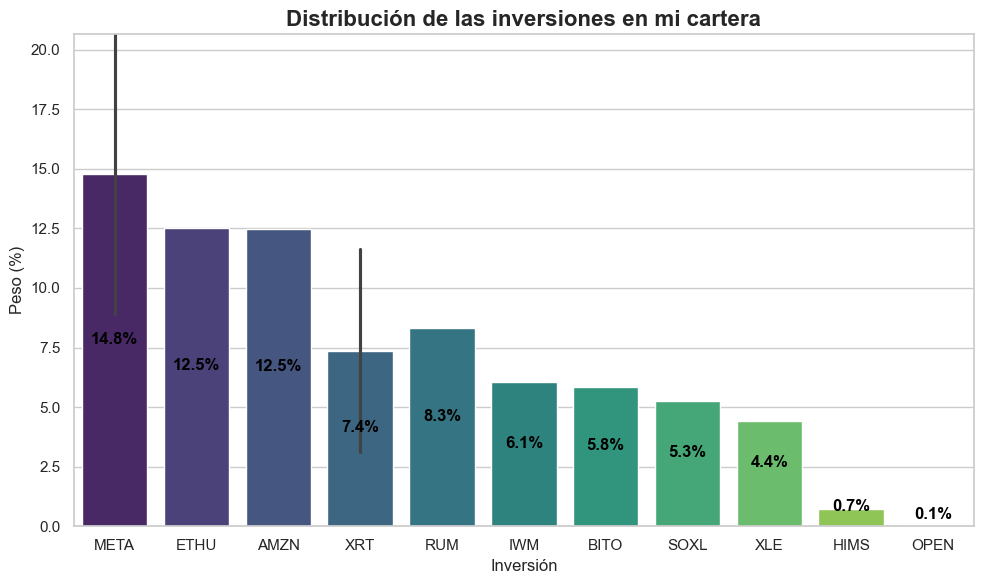

In [22]:
# Configurar estilo de Seaborn
sns.set(style="whitegrid")  # Establecer el estilo de fondo blanco con grid

# Crear gráfico de barras con Seaborn
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='symbol', y='peso', data=df_final, palette='viridis', legend=False)

# Personalizar el gráfico
bar_plot.set_title('Distribución de las inversiones en mi cartera', fontsize=16, weight='bold')
bar_plot.set_xlabel('Inversión', fontsize=12)
bar_plot.set_ylabel('Peso (%)', fontsize=12)
bar_plot.set_ylim(0, df_final.loc[:,"peso"].max())  # Asegurarse que el eje Y vaya de 0 a 100%

# Añadir etiquetas con los porcentajes sobre las barras
for p in bar_plot.patches:
    height = p.get_height()
    # Añadir el porcentaje encima de cada barra
    bar_plot.annotate(f'{height:.1f}%', 
                      (p.get_x() + p.get_width() / 2., height / 2), 
                      ha='center', va='center', 
                      fontsize=12, color='black', fontweight='bold', 
                      xytext=(0, 8), textcoords='offset points')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

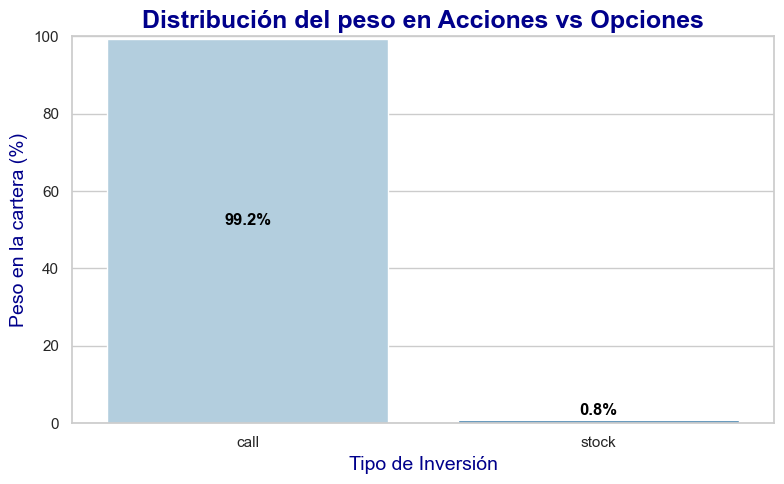

In [23]:
# Agrupar por right de inversión y sumar los pesos
df_grouped = df_final.groupby('right').agg({'peso': 'sum'}).reset_index()

# Configurar el estilo de Seaborn para un aspecto limpio
sns.set(style="whitegrid")  # Fondo blanco con líneas de cuadrícula

# Crear gráfico de barras con Seaborn
plt.figure(figsize=(8, 5))

# Usar una paleta de colores atractiva
bar_plot = sns.barplot(x='right', y='peso', data=df_grouped, palette='Blues', hue='right')

# Personalizar el gráfico
bar_plot.set_title('Distribución del peso en Acciones vs Opciones', fontsize=18, weight='bold', color='darkblue')
bar_plot.set_xlabel('Tipo de Inversión', fontsize=14, color='darkblue')
bar_plot.set_ylabel('Peso en la cartera (%)', fontsize=14, color='darkblue')
bar_plot.set_ylim(0, 100)  # Asegurarse de que el eje Y vaya de 0 a 100%

# Añadir etiquetas con los porcentajes sobre las barras
for p in bar_plot.patches:
    height = p.get_height()
    # Añadir el porcentaje encima de cada barra
    bar_plot.annotate(f'{height:.1f}%', 
                      (p.get_x() + p.get_width() / 2., height / 2), 
                      ha='center', va='center', 
                      fontsize=12, color='black', fontweight='bold', 
                      xytext=(0, 8), textcoords='offset points')

# Mejorar el espaciado del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

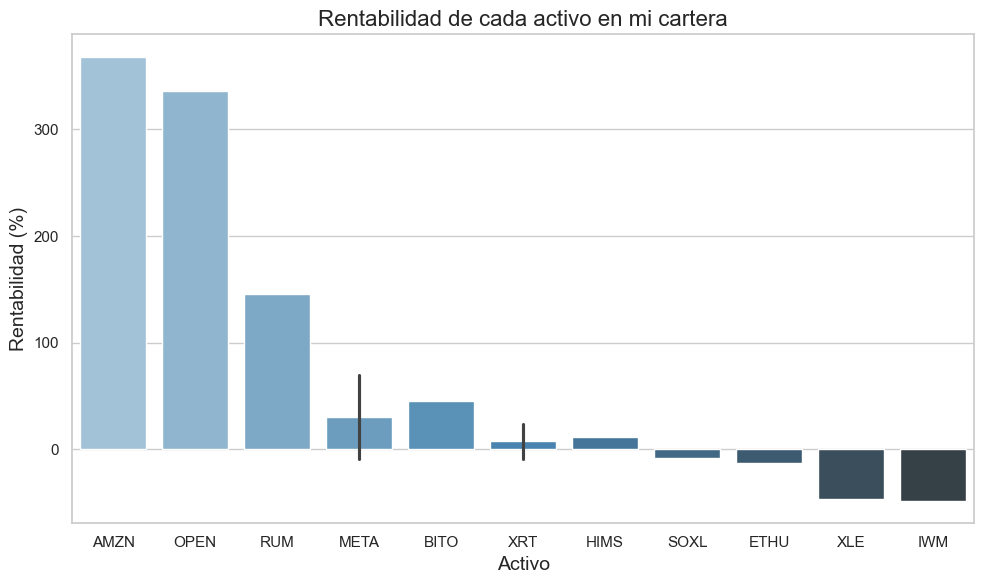

In [26]:
# Pintamos la info
# Crear un gráfico de barras de rentabilidad
plt.figure(figsize=(10, 6))
sns.barplot(
    x='symbol', 
    y='rentabilidad', 
    data=df_final.sort_values(by='rentabilidad', ascending=False), 
    palette='Blues_d', 
    hue='symbol'
    )

# Añadir título y etiquetas
plt.title('Rentabilidad de cada activo en mi cartera', fontsize=16)
plt.xlabel('Activo', fontsize=14)
plt.ylabel('Rentabilidad (%)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()
